In [1]:
import tensorflow as tf
from matplotlib import pyplot
from emnist import extract_training_samples, extract_test_samples
from tensorflow.keras import *
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import sys
import os
import zipfile
import tempfile
import tensorflow_model_optimization as tfmot
import json

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude


sys.path.insert(1, os.path.join(sys.path[0], '../../..'))

from utils import *

%matplotlib inline
%config Completer.use_jedi = False

tf.config.list_physical_devices('GPU')

[]

In [2]:
def get_gzipped_model_size(m):
    _, keras_file = tempfile.mkstemp('.h5')
    m.save(keras_file, include_optimizer=True)
    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(keras_file)
    return os.path.getsize(zipped_file)

INFO:emnist:Cached file found at /home/mdobrzanski/.cache/emnist/emnist.zip.
INFO:emnist:Cached file found at /home/mdobrzanski/.cache/emnist/emnist.zip.
INFO:emnist:Cached file found at /home/mdobrzanski/.cache/emnist/emnist.zip.
INFO:emnist:Cached file found at /home/mdobrzanski/.cache/emnist/emnist.zip.


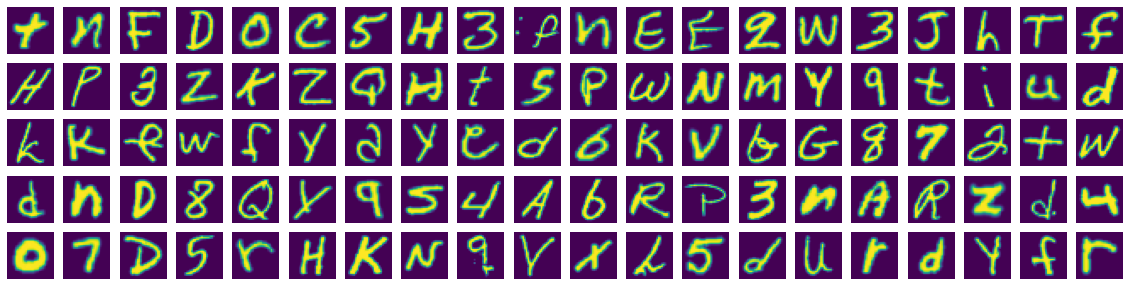

In [3]:
x_train, y_train = extract_training_samples('balanced')
x_test, y_test = extract_test_samples('balanced')

show_dataset(x_train)

In [4]:
num_classes = 47 

mean = np.mean(x_train,axis=(0, 1, 2))
std = np.std(x_train, axis=(0, 1, 2))

x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

y_train = utils.to_categorical(y_train, num_classes) 
y_test = utils.to_categorical(y_test, num_classes) 

In [5]:
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

In [6]:
model = tf.keras.models.load_model("vanilla_emnist.h5")

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


In [7]:
pprint(full_evaluate(model, x_test, y_test))

/home/mdobrzanski/anaconda3/envs/iet_env_um/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2424: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


{'accuracy_score': 0.9033510638297872,
 'f1_score_macro': 0.9025199833787635,
 'f1_score_weighted': 0.9041821442808109}


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0

# Weight prunning

In [9]:
results = {}

In [10]:
results['base'] = full_evaluate(model, x_test, y_test)
results['base']['size (kb)'] = os.stat('vanilla_emnist.h5').st_size//1024

In [11]:
batch_size = 256
epochs = 50

In [12]:
def train_sparse(model_for_pruning, epochs):
    model_for_pruning.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    logdir = tempfile.mkdtemp()

    callbacks = [
      tfmot.sparsity.keras.UpdatePruningStep(),
      tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
    ]

    model_for_pruning.fit(x_train, y_train,
                      batch_size=batch_size, epochs=epochs,
                      callbacks=callbacks)


    model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
    return model_for_export

In [13]:
# for p in [0.5, 0.7, 0.8, 0.85, 0.9, 0.925, 0.95, 0.975, 0.99]:
#     pruning_params = {
#           'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.2,
#                             final_sparsity=p,
#                             begin_step=0,
#                             end_step=np.ceil(x_train.shape[0] / batch_size).astype(np.int32) * epochs)
#     }

#     model_for_pruning = prune_low_magnitude(tf.keras.models.clone_model(model), **pruning_params)
#     model_for_pruning = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
#     model_for_export = train_sparse(model_for_pruning, int(epochs*p))
#     results['weight_pruning_{}'.format(p)] = full_evaluate(model_for_export, x_test, y_test)
#     results['weight_pruning_{}'.format(p)]['size (kb)'] = get_gzipped_model_size(model_for_export)//1024

In [14]:
# pprint(results)

In [15]:
# with open('results_pruning.json', 'w', encoding ='utf8') as json_file:
#     json.dump(results, json_file, ensure_ascii = True)

# Node prunning

In [16]:
with open('results_pruning.json', 'r', encoding ='utf8') as json_file:
    results = json.load(json_file)

In [19]:
model_tmp = tf.keras.models.clone_model(model)
# acc = []
# par_count =[]
models = [model_tmp]
model_tmp.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model_tmp = prune_model(model_tmp, 0.35, opt='adam', method='l1')
model_tmp.fit(x_train, y_train, batch_size=256, epochs=20, validation_data=(x_test, y_test), verbose=1)

for i in range(100):
    try:
        model_tmp = prune_model(model_tmp, 0.1, opt='adam', method='l1')
    except:
        break
    model_tmp.fit(x_train, y_train, batch_size=256, epochs=15, validation_data=(x_test, y_test), verbose=1)
    results['node_pruning_{}'.format((0.9)**(i+5))] = full_evaluate(model_tmp, x_test, y_test)
    results['node_pruning_{}'.format((0.9)**(i+5))]['params'] = model_tmp.count_params()
    results['node_pruning_{}'.format((0.9)**(i+5))]['size (kb)'] = get_gzipped_model_size(model_tmp)//1024
    with open('results_pruning.json', 'w', encoding ='utf8') as json_file:
        json.dump(results, json_file, ensure_ascii = True)

156
Deleting 28/128 channels from layer: conv2d_4


AttributeError: 'NoneType' object has no attribute 'op'